<a href="https://colab.research.google.com/github/irawan09/Baldness_Detection/blob/master/Thesis_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gpu==2.0.0
!pip install tensorflow_hub

     |████████████████████████████████| 380.8MB 43kB/s 
     |████████████████████████████████| 450kB 45.5MB/s 
     |████████████████████████████████| 51kB 4.0MB/s 
     |████████████████████████████████| 3.8MB 20.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7557 sha256=be35fd94987699d92666dc0bc70e4058705fe917433d28f6fb5d7253a202ce5d
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.5.0 has requirement gast==0.4.0, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement tensorflow-estimator<2.6.0,>=2.5.0rc0, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing insta

In [ ]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip

--2021-06-28 08:26:57--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.121.24
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.121.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  56.8MB/s    in 24s     

2021-06-28 08:27:22 (57.0 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [ ]:
import zipfile

with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [ ]:
!mkdir -p data_faces/hairy
!mkdir -p data_faces/bald

In [ ]:
import os
import cv2

root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print("number of datasets : ",len(img_list))

number of datasets :  202599


In [ ]:
import numpy as np
import pandas as pd
import requests
import io

url_attributes = 'https://raw.githubusercontent.com/irawan09/Baldness_Detection/master/list_attr_celeba.csv'

download_attributes = requests.get(url_attributes).content
df_attr = pd.read_csv(io.StringIO(download_attributes.decode('utf-8')))
df_attr.replace(to_replace=-1, value=0, inplace=True)

data = df_attr[['image_id', 'Bald']]
data.head()

,image_id,Bald
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


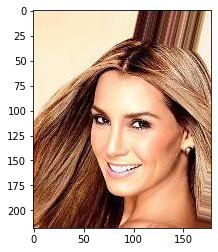

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img = mpimg.imread('data_faces/img_align_celeba/000001.jpg')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
def move_file(old_file_path, new_directory):
    if not os.path.isdir(new_directory):
        os.mkdir(new_directory)
    base_name = os.path.basename(old_file_path)
    new_file_path = os.path.join(new_directory, base_name)
    # Deletes a file if that file already exists there, you can change this behavior
    if os.path.exists(new_file_path):
        os.remove(new_file_path)
    os.rename(old_file_path, new_file_path)

In [ ]:
cop_folder = 'data_faces/img_align_celeba'

dir_bald = 'data_faces/bald'
dir_hairy = 'data_faces/hairy'

for id, bald in zip(data.iloc[:, 0], data.iloc[:, 1]):
    filename = os.path.join(cop_folder, id)
    if bald == 0:
        move_file(filename, dir_hairy)
    else:
        move_file(filename, dir_bald)

In [ ]:
hairy_list = os.listdir(dir_hairy)
bald_list = os.listdir(dir_bald)
print("number of hairy images : ",len(hairy_list))
print("number of bald images : ",len(bald_list))

number of hairy images :  198052
number of bald images :  4547


In [ ]:
!rm -rf data_faces/img_align_celeba
!rm -rf /content/celeba.zip

In [ ]:
import random

files = random.sample(hairy_list, 193505)  # Pick 193505 random files

for file in files:  # Go over each file name to be deleted
        f = os.path.join(dir_hairy, file)  # Create valid path to file
        os.remove(f)  # Remove the file

In [ ]:
hairy_list = os.listdir(dir_hairy)
bald_list = os.listdir(dir_bald)
print("number of hairy images : ",len(hairy_list))
print("number of bald images : ",len(bald_list))

number of hairy images :  4547
number of bald images :  4547


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [ ]:
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.0.0
Hub version:  0.12.0
Eager mode:  True
GPU is NOT AVAILABLE


In [ ]:
data_root = 'data_faces/'

IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rotation_range=30,
                      width_shift_range=0.2,
                      height_shift_range=0.2,
                      shear_range=0.2,
                      zoom_range=0.2,
                      horizontal_flip=True, 
                      rescale=1./255, 
                      validation_split=.9)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 8184 images belonging to 2 classes.
Found 910 images belonging to 2 classes.


In [ ]:
# Learn more about data batches

image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 2)


In [ ]:
# Learn about dataset labels

dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Bald' 'Hairy']


In [ ]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  2257984   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [ ]:
# Run model training

steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator, 
    epochs=10,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Train for 29.0 steps, validate for 256.0 steps
Epoch 1/10
29/29 [==============================] - 597s 21s/step - loss: 0.7067 - acc: 0.6495 - val_loss: 0.3988 - val_acc: 0.8176
Epoch 2/10
29/29 [==============================] - 571s 20s/step - loss: 0.4229 - acc: 0.8121 - val_loss: 0.3327 - val_acc: 0.8617
Epoch 3/10
29/29 [==============================] - 554s 19s/step - loss: 0.3201 - acc: 0.8637 - val_loss: 0.2818 - val_acc: 0.8810
Epoch 4/10
29/29 [==============================] - 557s 19s/step - loss: 0.2882 - acc: 0.8703 - val_loss: 0.2699 - val_acc: 0.8908
Epoch 5/10
29/29 [==============================] - 557s 19s/step - loss: 0.2852 - acc: 0.8846 - val_loss: 0.2616 - val_acc: 0.8877
Epoch 6/10
29/29 [==============================] - 828s 29s/step - loss: 0.2684 - acc: 0.8934 - val_loss: 0.2597 - val_acc: 0.8924
Epoch 7/10
29/29 [==============================] - 819s 28s/step - loss: 0.2629 - acc: 0.8967 - val_loss: 0.2573 - val_acc: 0.8935
Epoch 8/10
29/29 [===========

In [ ]:
# Measure accuracy and loss after training

final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)

256/256 [==============================] - 899s 4s/step - loss: 0.2345 - acc: 0.9057


In [ ]:
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

Final loss: 0.23
Final accuracy: 90.57%


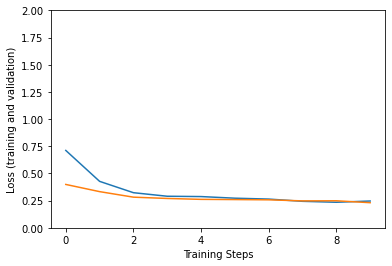

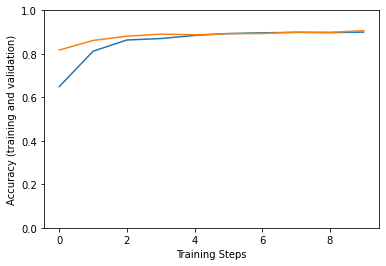

In [ ]:
# Visualize training process

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

In [ ]:
BALD_SAVED_MODEL = "saved_models/baldness3"
tf.saved_model.save(model, BALD_SAVED_MODEL)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: saved_models/baldness3/assets


INFO:tensorflow:Assets written to: saved_models/baldness3/assets


In [ ]:
# Load SavedModel

bald_model = hub.load(BALD_SAVED_MODEL)
print(bald_model)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7ff77137c350>


In [ ]:
# Get images and labels batch from validation dataset generator

val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [ ]:
tf_model_predictions = bald_model(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 2)


In [ ]:
# Convert prediction results to Pandas dataframe, for better visualization

tf_pred_dataframe = pd.DataFrame(tf_model_predictions.numpy())
tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,Bald,Hairy
0,0.92279255,0.07720739
1,0.96850276,0.03149729
2,0.35042912,0.64957082
3,0.94913042,0.05086959
4,0.94979894,0.05020111


In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

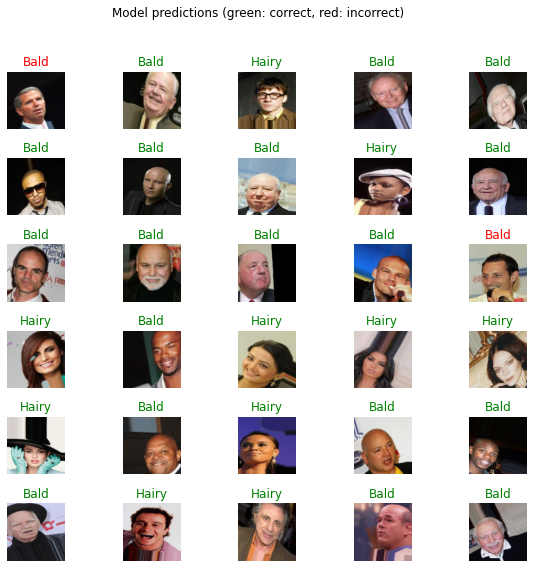

In [ ]:
# Print images batch and labels predictions

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [ ]:
!mkdir "tflite_models"

In [ ]:
TFLITE_MODEL = "tflite_models/baldness.tflite"
TFLITE_QUANT_MODEL = "tflite_models/baldness_quant.tflite"

In [ ]:
# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : bald_model(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

# Convert the model to quantized version with post-training quantization
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)

print("TFLite models and their sizes:")
!ls "tflite_models" -lh

TFLite models and their sizes:
total 11M
-rw-r--r-- 1 root root 2.3M Jun 28 10:49 baldness_quant.tflite
-rw-r--r-- 1 root root 8.5M Jun 28 10:49 baldness.tflite


In [ ]:
# Load TFLite model and see some details about input/output

tflite_interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: x
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [1 2]
type: <class 'numpy.float32'>


In [ ]:
tflite_interpreter.resize_tensor_input(input_details[0]['index'], (32, 224, 224, 3))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (32, 5))
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: x
shape: [ 32 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [32  2]
type: <class 'numpy.float32'>


In [ ]:
tflite_interpreter.set_tensor(input_details[0]['index'], val_image_batch)

tflite_interpreter.invoke()

tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)

Prediction results shape: (32, 2)


In [ ]:
# Convert prediction results to Pandas dataframe, for better visualization

tflite_pred_dataframe = pd.DataFrame(tflite_model_predictions)
tflite_pred_dataframe.columns = dataset_labels

print("TFLite prediction results for the first elements")
tflite_pred_dataframe.head()

TFLite prediction results for the first elements


,Bald,Hairy
0,0.92279208,0.07720795
1,0.96850252,0.03149744
2,0.35042745,0.64957249
3,0.94912964,0.05087034
4,0.94979906,0.05020102


In [ ]:
# Load quantized TFLite model
tflite_interpreter_quant = tf.lite.Interpreter(model_path=TFLITE_QUANT_MODEL)

# Learn about its input and output details
input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

# Resize input and output tensors to handle batch of 32 images
tflite_interpreter_quant.resize_tensor_input(input_details[0]['index'], (32, 224, 224, 3))
tflite_interpreter_quant.resize_tensor_input(output_details[0]['index'], (32, 5))
tflite_interpreter_quant.allocate_tensors()

input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

# Run inference
tflite_interpreter_quant.set_tensor(input_details[0]['index'], val_image_batch)

tflite_interpreter_quant.invoke()

tflite_q_model_predictions = tflite_interpreter_quant.get_tensor(output_details[0]['index'])
print("\nPrediction results shape:", tflite_q_model_predictions.shape)

== Input details ==
name: x
shape: [ 32 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [32  2]
type: <class 'numpy.float32'>

Prediction results shape: (32, 2)


In [ ]:
# Convert prediction results to Pandas dataframe, for better visualization

tflite_q_pred_dataframe = pd.DataFrame(tflite_q_model_predictions)
tflite_q_pred_dataframe.columns = dataset_labels

print("Quantized TFLite model prediction results for the first elements")
tflite_q_pred_dataframe.head()

Quantized TFLite model prediction results for the first elements


,Bald,Hairy
0,0.43388239,0.56611758
1,0.35453054,0.64546943
2,0.15066835,0.84933168
3,0.66465360,0.33534637
4,0.78503013,0.21496987


In [ ]:
# Concatenate results from all models

all_models_dataframe = pd.concat([tf_pred_dataframe, 
                                  tflite_pred_dataframe, 
                                  tflite_q_pred_dataframe], 
                                 keys=['TF Model', 'TFLite', 'TFLite quantized'],
                                 axis='columns')
all_models_dataframe.head()

TF Model                  TFLite             TFLite quantized            
         Bald       Hairy        Bald       Hairy             Bald       Hairy
0  0.92279255  0.07720739  0.92279208  0.07720795       0.43388239  0.56611758
1  0.96850276  0.03149729  0.96850252  0.03149744       0.35453054  0.64546943
2  0.35042912  0.64957082  0.35042745  0.64957249       0.15066835  0.84933168
3  0.94913042  0.05086959  0.94912964  0.05087034       0.66465360  0.33534637
4  0.94979894  0.05020111  0.94979906  0.05020102       0.78503013  0.21496987

In [ ]:
# Swap columns to hava side by side comparison

all_models_dataframe = all_models_dataframe.swaplevel(axis='columns')[tflite_pred_dataframe.columns]
all_models_dataframe.head()

Bald              ...       Hairy                 
     TF Model      TFLite  ...      TFLite TFLite quantized
0  0.92279255  0.92279208  ...  0.07720795       0.56611758
1  0.96850276  0.96850252  ...  0.03149744       0.64546943
2  0.35042912  0.35042745  ...  0.64957249       0.84933168
3  0.94913042  0.94912964  ...  0.05087034       0.33534637
4  0.94979894  0.94979906  ...  0.05020102       0.21496987

[5 rows x 6 columns]

In [ ]:
# Highlight TFLite models predictions that are different from original model

def highlight_diff(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    other = data.xs('TF Model', axis='columns', level=-1)
    return pd.DataFrame(np.where(data.ne(other, level=0), attr, ''),
                        index=data.index, columns=data.columns)

all_models_dataframe.style.apply(highlight_diff, axis=None)

In [ ]:
# Concatenation of argmax and max value for each row
def max_values_only(data):
  argmax_col = np.argmax(data, axis=1).reshape(-1, 1)
  max_col = np.max(data, axis=1).reshape(-1, 1)
  return np.concatenate([argmax_col, max_col], axis=1)

# Build simplified prediction tables
tf_model_pred_simplified = max_values_only(tf_model_predictions)
tflite_model_pred_simplified = max_values_only(tflite_model_predictions)
tflite_q_model_pred_simplified = max_values_only(tflite_q_model_predictions)

In [ ]:
# Build DataFrames and present example
columns_names = ["Label_id", "Confidence"]
tf_model_simple_dataframe = pd.DataFrame(tf_model_pred_simplified)
tf_model_simple_dataframe.columns = columns_names

tflite_model_simple_dataframe = pd.DataFrame(tflite_model_pred_simplified)
tflite_model_simple_dataframe.columns = columns_names

tflite_q_model_simple_dataframe = pd.DataFrame(tflite_q_model_pred_simplified)
tflite_q_model_simple_dataframe.columns = columns_names

tf_model_simple_dataframe.head()

,Label_id,Confidence
0,0.0,0.92279255
1,0.0,0.96850276
2,1.0,0.64957082
3,0.0,0.94913042
4,0.0,0.94979894


In [ ]:
# Concatenate results from all models
all_models_simple_dataframe = pd.concat([tf_model_simple_dataframe, 
                                         tflite_model_simple_dataframe, 
                                         tflite_q_model_simple_dataframe], 
                                        keys=['TF Model', 'TFLite', 'TFLite quantized'],
                                        axis='columns')

# Swap columns for side-by-side comparison
all_models_simple_dataframe = all_models_simple_dataframe.swaplevel(axis='columns')[tf_model_simple_dataframe.columns]

# Highlight differences
all_models_simple_dataframe.style.apply(highlight_diff, axis=None)

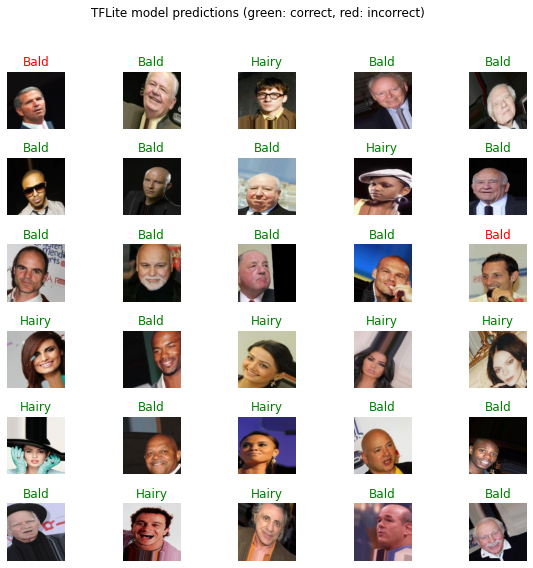

In [ ]:
# Print images batch and labels predictions for TFLite Model

tflite_predicted_ids = np.argmax(tflite_model_predictions, axis=-1)
tflite_predicted_labels = dataset_labels[tflite_predicted_ids]
tflite_label_id = np.argmax(val_label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if tflite_predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(tflite_predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("TFLite model predictions (green: correct, red: incorrect)")

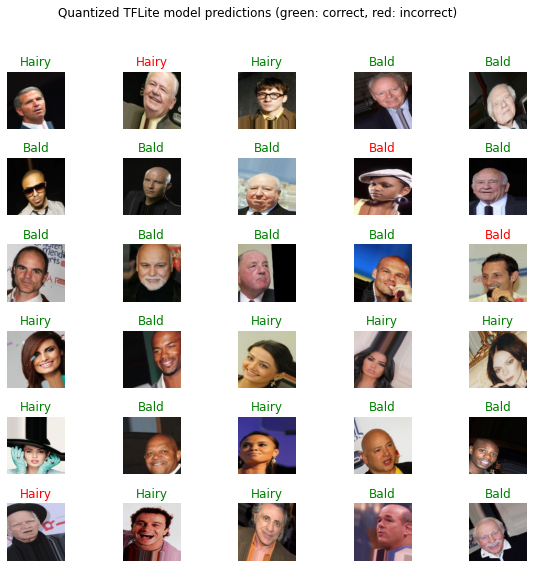

In [ ]:
# Print images batch and labels predictions for TFLite Model

tflite_q_predicted_ids = np.argmax(tflite_q_model_predictions, axis=-1)
tflite_q_predicted_labels = dataset_labels[tflite_q_predicted_ids]
tflite_q_label_id = np.argmax(val_label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if tflite_q_predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(tflite_q_predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Quantized TFLite model predictions (green: correct, red: incorrect)")

In [ ]:
from PIL import Image

In [ ]:
VAL_BATCH_DIR = "validation_batch"

In [ ]:
!mkdir {VAL_BATCH_DIR}

In [ ]:
# Export batch to *.jpg files with specific naming convention.
# Make sure they are exported in the full quality, otherwise the inference
# process will return different results. 

for n in range(32):
  filename = "n{:0.0f}_true{:0.0f}_pred{:0.0f}.jpg".format(
      n,
      true_label_ids[n],
      tflite_model_pred_simplified[n][0]
  )
  img_arr = np.copy(val_image_batch[n])
  img_arr *= 255
  img_arr = img_arr.astype("uint8")
  img11 = Image.fromarray(img_arr, 'RGB')
  img11.save("{}/{}".format(VAL_BATCH_DIR, filename), "JPEG", quality=100)

In [ ]:
!tar -zcvf {VAL_BATCH_DIR}.tar.gz {VAL_BATCH_DIR}

validation_batch/
validation_batch/n16_true0_pred0.jpg
validation_batch/n22_true1_pred1.jpg
validation_batch/n10_true0_pred0.jpg
validation_batch/n6_true0_pred0.jpg
validation_batch/n5_true0_pred0.jpg
validation_batch/n30_true1_pred1.jpg
validation_batch/n24_true0_pred0.jpg
validation_batch/n20_true1_pred1.jpg
validation_batch/n26_true1_pred1.jpg
validation_batch/n9_true0_pred0.jpg
validation_batch/n17_true1_pred1.jpg
validation_batch/n12_true0_pred0.jpg
validation_batch/n28_true0_pred0.jpg
validation_batch/n15_true1_pred1.jpg
validation_batch/n14_true1_pred0.jpg
validation_batch/n27_true1_pred1.jpg
validation_batch/n25_true0_pred0.jpg
validation_batch/n8_true1_pred1.jpg
validation_batch/n7_true0_pred0.jpg
validation_batch/n23_true0_pred0.jpg
validation_batch/n0_true1_pred0.jpg
validation_batch/n13_true0_pred0.jpg
validation_batch/n21_true0_pred0.jpg
validation_batch/n3_true0_pred0.jpg
validation_batch/n29_true0_pred0.jpg
validation_batch/n19_true1_pred1.jpg
validation_batch/n1_true0_p